# 🚀 Ignition + CIFAR10

A basic demo of using Ignition to train a CIFAR-10 model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Allow Python to find ignition.
import sys
sys.path.insert(0, "../")

In [3]:
import importlib
import ignition; importlib.reload(ignition)
from ignition import *

In [4]:
ignition.__version__

'0.0.1'

In [5]:
ignition.print_cuda_info()

cuDNN version: 7003
Available CUDA devices:
0: GeForce GTX 1080 Ti, capability 6.1 (current)


## The model

This is only a very basic convnet. Not particulary state-of-the-art. ;-)

In [6]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv(3, 16, 3)
        self.conv2 = Conv(16, 32, 3)
        self.conv3 = Conv(32, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.avg_pool2d(self.conv2(x), 2)
        x = F.avg_pool2d(self.conv3(x), 2)
        x = x.view(-1, flattened_size(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # logits

In [7]:
net = Net()
_ = net.cuda()

Show a summary of the model's parameters.

In [8]:
print_parameter_sizes(net)

Parameter                      | Size                     | Count        | Train?
conv1.conv.weight              | 16 × 3 × 3 × 3           |          432 | Yes   
conv1.conv.bias                | 16                       |           16 | Yes   
conv1.bn.weight                | 16                       |           16 | Yes   
conv1.bn.bias                  | 16                       |           16 | Yes   
conv2.conv.weight              | 32 × 16 × 3 × 3          |         4608 | Yes   
conv2.conv.bias                | 32                       |           32 | Yes   
conv2.bn.weight                | 32                       |           32 | Yes   
conv2.bn.bias                  | 32                       |           32 | Yes   
conv3.conv.weight              | 64 × 32 × 3 × 3          |        18432 | Yes   
conv3.conv.bias                | 64                       |           64 | Yes   
conv3.bn.weight                | 64                       |           64 | Yes   
conv3.bn.bias   

Show the shapes of the tensors at every layer for a 32×32 input image.

In [9]:
print_activation_sizes(net, (1, 3, 32, 32))

Module                         | Input Size               | Output Size             
conv1                          | 1 × 3 × 32 × 32          | 1 × 16 × 32 × 32        
conv2                          | 1 × 16 × 16 × 16         | 1 × 32 × 16 × 16        
conv3                          | 1 × 32 × 8 × 8           | 1 × 64 × 8 × 8          
fc1                            | 1 × 1024                 | 1 × 128                 
fc2                            | 1 × 128                  | 1 × 10                  


In [10]:
print_activation_sizes(net.conv1, (1, 3, 32, 32))

Module                         | Input Size               | Output Size             
conv                           | 1 × 3 × 32 × 32          | 1 × 16 × 32 × 32        
bn                             | 1 × 16 × 32 × 32         | 1 × 16 × 32 × 32        


Show a picture of the model:

In [ ]:
plot_graph(net, (1, 3, 32, 32))

PyTorch will now have allocated tensors for the weights and their gradients.

In [11]:
dump_tensors()

Parameter → FloatTensor: GPU pinned grad 16 × 3 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 16
Parameter → FloatTensor: GPU pinned grad 32 × 16 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 32
Parameter → FloatTensor: GPU pinned grad 64 × 32 × 3 × 3
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 64
Parameter → FloatTensor: GPU pinned grad 128 × 1024
Parameter → FloatTensor: GPU pinned grad 128
Parameter → FloatTensor: GPU pinned grad 10 × 128
Parameter → FloatTensor: GPU pinned grad 10
FloatTensor: GPU pinned 16 × 3 × 3 × 3
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 16
FloatTensor: GPU pinned 32 × 16 × 3 × 3
FloatTensor: GPU pinned 32
Fl

In [ ]:
!nvidia-smi

## The dataset

In [8]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)

CIFAR-10 data is often preprocessed using ZCA whitening but we just normalize it using the mean and stddev over the training set.

In [9]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [10]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, 
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, 
                                         num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
print("Train examples:", data_loader_sample_count(trainloader))
print(" Test examples:", data_loader_sample_count(testloader))

Train examples: 50000
 Test examples: 10000


Look at some of the data:

In [12]:
def untransform(img):
    mean = torch.Tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.Tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    return torch.clamp(img*std + mean, 0., 1.)

In [320]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

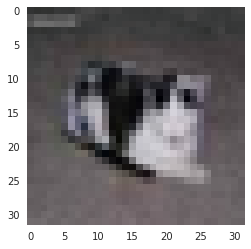

In [321]:
imshow(images[0], untransform)

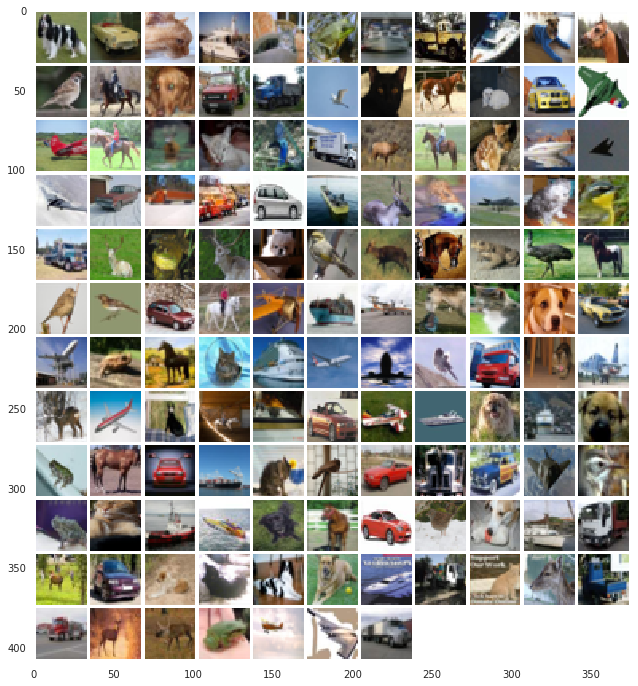

In [21]:
grid = torchvision.utils.make_grid(images, pad_value=255, nrow=int(np.sqrt(batch_size)))
imshow(grid, untransform, figsize=(12, 12))

## Training

Create output folder where we'll store the trained model and intermediate checkpoints.

In [13]:
output_dir = "checkpoints/cifar10/"
mkdir_if_needed(output_dir)

Define the loss function:

In [14]:
crossentropy_loss = nn.CrossEntropyLoss()

Define the evaluation function. Since this is a classifier we use the built-in `evaluate_on_batch()`.

In [15]:
def eval_fn(model_to_eval, x, y):
    return evaluate_on_batch(model_to_eval, x, y, crossentropy_loss, ["loss", "acc"])

Evaluating an untrained model on the test set should give initial loss of `-ln(1/num_classes) = 2.30258`. Initial accuracy should be `1/num_classes = 0.1`. These values are approximate because of the random initialization of the layers.

In [14]:
evaluate(net, eval_fn, testloader)

79 steps - 0s - loss: 2.30417, acc: 0.10000                              


{'acc': 0.1, 'loss': 2.304174869875365}

Create the optimizer:

In [41]:
lr = 0.05
optimizer = optim.SGD(trainable_parameters(net), lr=lr, momentum=0.9, weight_decay=1e-4)

Define the training function. This uses the built-in `fit_on_batch()`.

In [42]:
def train_fn(model, x, y):
    return fit_on_batch(model, x, y, crossentropy_loss, optimizer)

Create the trainer object that performs the actual training loop. Note that the trainer does not know anything about how the actual training happens.

In [43]:
trainer = Trainer(net, train_fn, trainloader, eval_fn, testloader)

Define a callback that saves a model checkpoint after every 10 epochs. This also includes the training history.

In [44]:
filename = output_dir + "mymodel_ep{epoch:d}_loss{val_loss:.4f}_acc{val_acc:.4f}.pt"
trainer.callbacks = [ SaveModel(filename, include_history=True, save_every=10, 
                                always_save_better=False, verbose=True) ]

Start training!

In [45]:
trainer.fit(epochs=20)

Train epochs 1-20 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
 1/20   |   391 | 1s    |  1.37049 | 0.50028 |  1.10317 | 0.59940
 2/20   |   391 | 1s    |  0.97992 | 0.65248 |  1.07595 | 0.62730                                    
 3/20   |   391 | 1s    |  0.82947 | 0.70726 |  0.83116 | 0.71050                                    
 4/20   |   391 | 1s    |  0.73891 | 0.73962 |  0.81944 | 0.71130                                    
 5/20   |   391 | 1s    |  0.67722 | 0.76278 |  0.79444 | 0.72770                                    
 6/20   |   391 | 1s    |  0.62879 | 0.77836 |  0.74873 | 0.74060                                    
 7/20   |   391 | 1s    |  0.59378 | 0.79020 |  0.67967 | 0.76670                                    
 8/20   |   391 | 1s    |  0.55484 | 0.80308 |  0.73217 | 0.75160                                    
 9/20   |   391 | 1s    |  0.53463 | 0.81170 |  0.6890

How have we been doing so far?

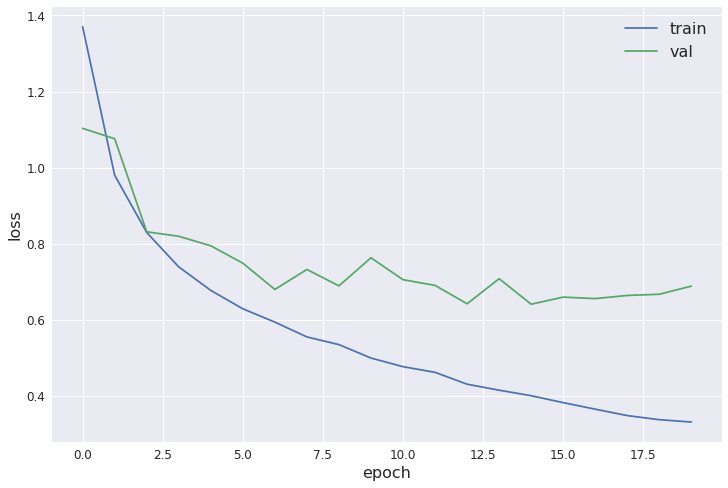

In [46]:
trainer.history.plot_loss()

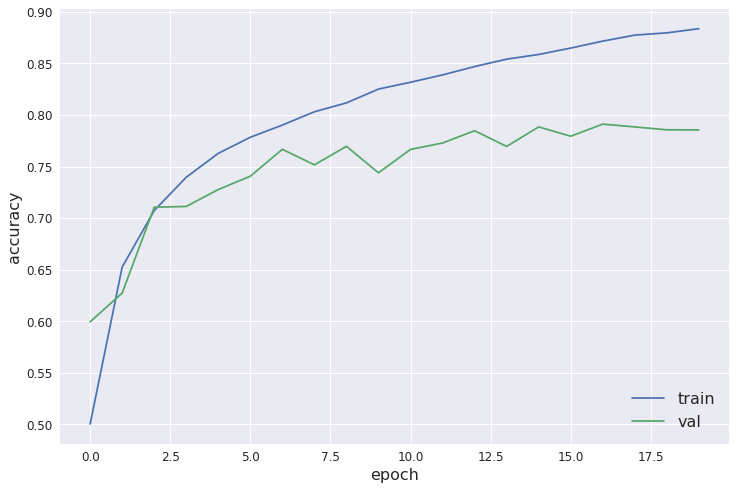

In [47]:
trainer.history.plot_accuracy()

Manual learning rate annealing:

In [48]:
lr *= 0.1; set_lr(optimizer, lr); lr

0.005000000000000001

From now on, still save a checkpoint every 10 epochs but also whenever the validation accuracy improves.

In [49]:
trainer.callbacks[0].always_save_better=True

In [50]:
trainer.fit(epochs=10)

Train epochs 21-30 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
21/30   |   391 | 1s    |  0.22125 | 0.92762 |  0.58862 | 0.81590
😊 val_acc improved from 0.7911 to 0.8159
💾 Saving model to checkpoints/cifar10/mymodel_ep21_loss0.5886_acc0.8159.pt
22/30   |   391 | 1s    |  0.19452 | 0.93734 |  0.59641 | 0.81830                                    
😊 val_acc improved from 0.8159 to 0.8183
💾 Saving model to checkpoints/cifar10/mymodel_ep22_loss0.5964_acc0.8183.pt
23/30   |   391 | 1s    |  0.17891 | 0.94228 |  0.60165 | 0.82010                                    
😊 val_acc improved from 0.8183 to 0.8201
💾 Saving model to checkpoints/cifar10/mymodel_ep23_loss0.6017_acc0.8201.pt
24/30   |   391 | 1s    |  0.17294 | 0.94488 |  0.61245 | 0.82010                                    
25/30   |   391 | 1s    |  0.16574 | 0.94716 |  0.61677 | 0.81960                                    
26/30   |  

In [51]:
lr *= 0.1; set_lr(optimizer, lr); lr

0.0005000000000000001

In [52]:
trainer.fit(epochs=10)

Train epochs 31-40 on 50000 examples, validate on 10000 examples
epoch   | steps | time  | tr loss  | tr acc  | val loss | val acc                                    
31/40   |   391 | 1s    |  0.12720 | 0.96256 |  0.64452 | 0.81790
32/40   |   391 | 1s    |  0.12543 | 0.96306 |  0.64828 | 0.81870                                    
33/40   |   391 | 1s    |  0.12499 | 0.96342 |  0.64565 | 0.82160                                    
😊 val_acc improved from 0.8205 to 0.8216
💾 Saving model to checkpoints/cifar10/mymodel_ep33_loss0.6456_acc0.8216.pt
34/40   |   391 | 1s    |  0.12217 | 0.96534 |  0.64811 | 0.81910                                    
35/40   |   391 | 1s    |  0.12281 | 0.96450 |  0.64853 | 0.81940                                    
36/40   |   391 | 1s    |  0.12390 | 0.96320 |  0.64998 | 0.81990                                    
37/40   |   391 | 1s    |  0.12122 | 0.96458 |  0.65341 | 0.81890                                    
38/40   |   391 | 1s    |  0.12108 | 0.

Plot the loss and accuracy curves.

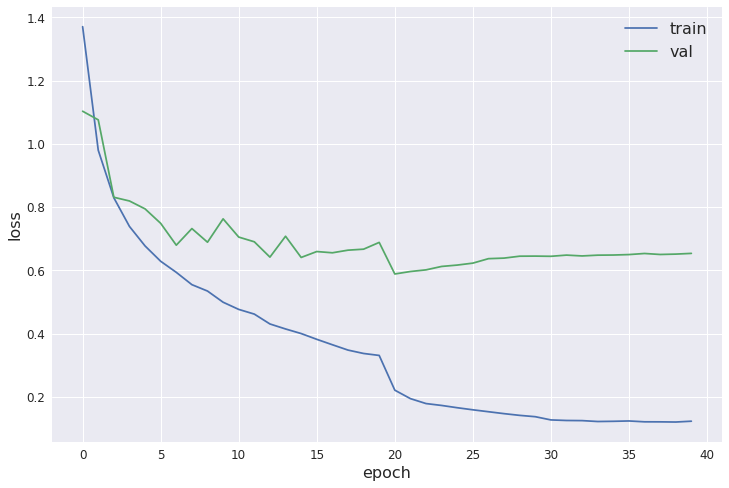

In [53]:
trainer.history.plot_loss()

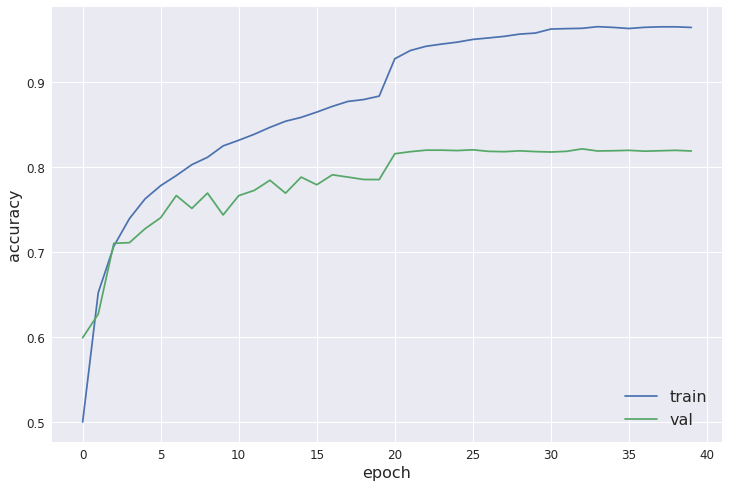

In [54]:
trainer.history.plot_accuracy()

In [55]:
trainer.history.best_epoch()

{'epoch': 32, 'val_acc': 0.8216}

(Note that we count epochs from 0 but the progress report starts counting from 1, so this best epoch was actually saved as "33" rather than 32.)

## Evaluating the model

Load the best checkpoint:

In [16]:
checkpoint = torch.load(output_dir + "mymodel_ep33_loss0.6456_acc0.8216.pt")
net.load_state_dict(checkpoint["model"])

In [17]:
evaluate(net, eval_fn, testloader)

79 steps - 0s - loss: 0.64565, acc: 0.82160                              


{'acc': 0.8216, 'loss': 0.6456469719922995}

Run prediction over the test set:

In [131]:
y_pred = predict(net, testloader, verbose=True)

79/79 ██████████████████████████████ ETA 0s


In [132]:
y_pred_idx = from_onehot(y_pred)
len(y_pred), len(y_pred_idx)

(10000, 10000)

In [133]:
y_val = testset.test_labels

Confusion matrix

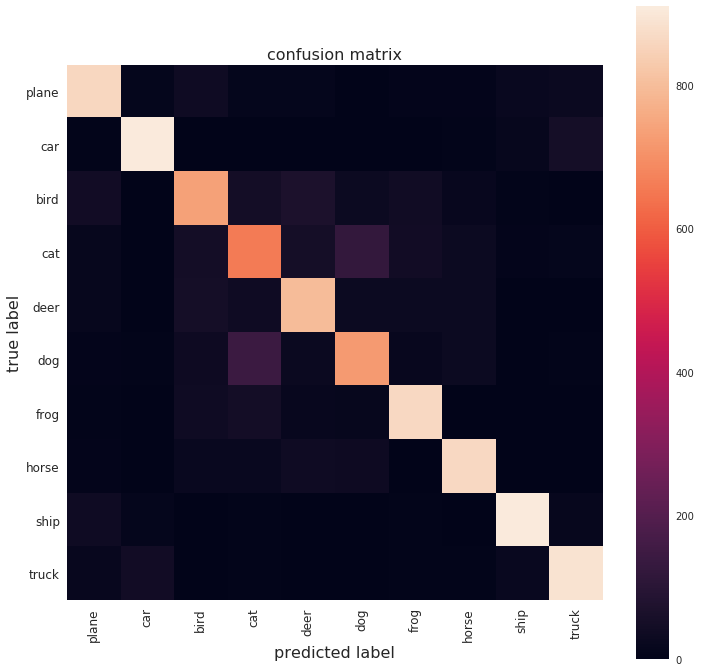

In [134]:
confusion_matrix(y_val, y_pred_idx, classes)

How often does each class get predicted?

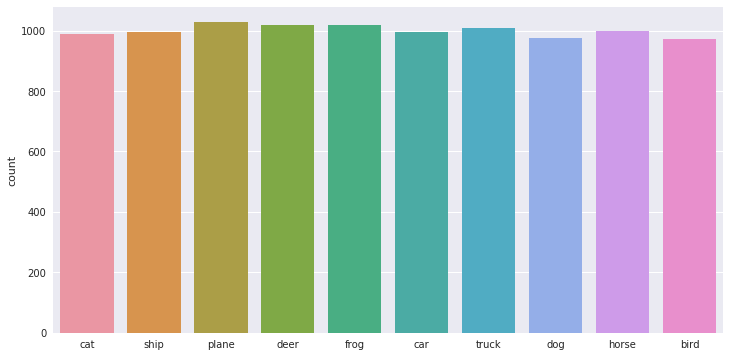

In [23]:
plot_target_counts(y_pred_idx, classes)

Precision / recall

In [24]:
precision_recall(y_val, y_pred_idx, classes)

             precision    recall  f1-score   support

      plane       0.84      0.86      0.85      1000
        car       0.91      0.91      0.91      1000
       bird       0.76      0.74      0.75      1000
        cat       0.67      0.66      0.66      1000
       deer       0.78      0.80      0.79      1000
        dog       0.74      0.72      0.73      1000
       frog       0.85      0.86      0.86      1000
      horse       0.86      0.86      0.86      1000
       ship       0.91      0.91      0.91      1000
      truck       0.88      0.89      0.89      1000

avg / total       0.82      0.82      0.82     10000



The network outputs logits, so compute the softmax to convert the predictions to percentages:

In [135]:
y_pred_softmax = F.softmax(make_var(y_pred), dim=1)
y_pred_softmax.shape

torch.Size([10000, 10])

In [136]:
y_pred_ = y_pred_softmax.data.cpu().numpy()
y_true_ = np.array(y_val)

## Correct vs. incorrect predictions

Look at some random correct predictions for cat:

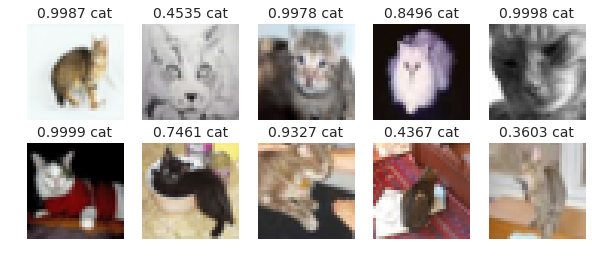

In [137]:
plot_random_correct(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

And some random incorrect predictions for cat. (The probability is for class cat, the label is the true label.)

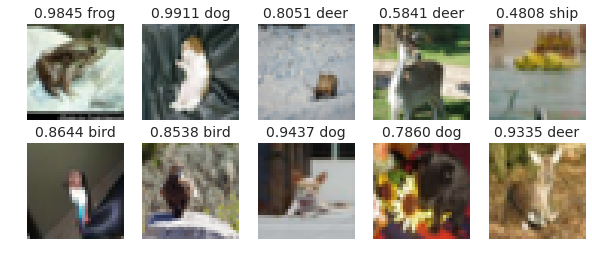

In [138]:
plot_random_incorrect(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

Correct predictions for cats with the highest confidence:

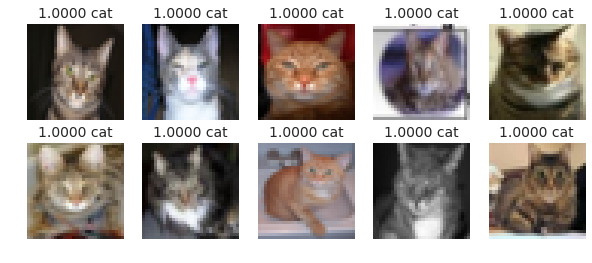

In [139]:
plot_most_confident_correct(3, y_pred_, y_true_, testset.test_data, classes, nrows=2)

And with the lowest confidence:

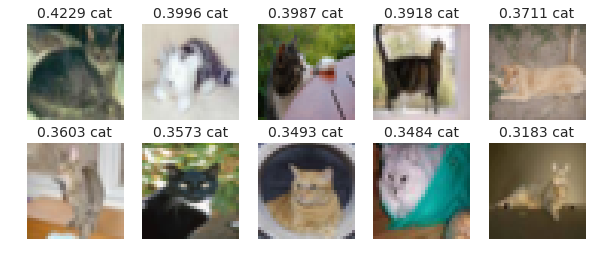

In [140]:
plot_least_confident_correct(3, y_pred_, y_true_, testset, classes, 
                             nrows=2, untransform=untransform)

Show the images that were most confidently classified as "cat" but aren't. This is the error in precision. (The labels shown are the true labels.)

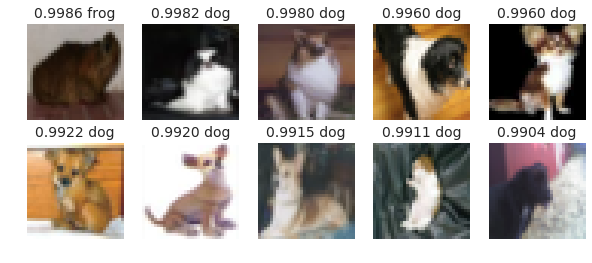

In [141]:
plot_most_confident_incorrect_by_precision(3, y_pred_, y_true_, testset, classes, 
                                           nrows=2, untransform=untransform)

Show the images that were classified as "cat" but aren't, but where the confidence is quite low.

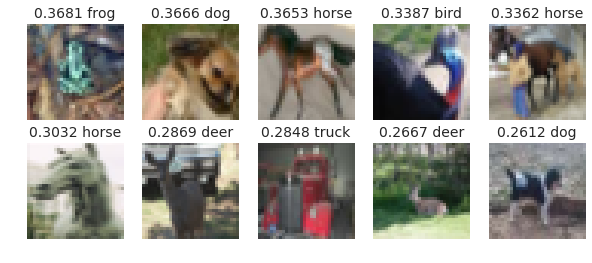

In [142]:
plot_least_confident_incorrect_by_precision(3, y_pred_, y_true_, testset, classes, 
                                            nrows=2, untransform=untransform)

Show the images that are cats but are confidently classified to be something else, i.e. these are examples that the model "missed". This is the error in recall. (The percentages shown are the predicted probabilities for cat, because that's the class we're interested in. The labels are what the model predicted; the true label is "cat".)

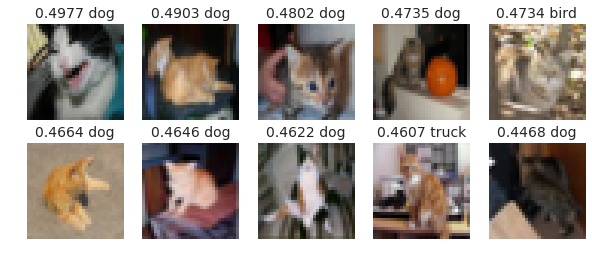

In [143]:
plot_most_confident_incorrect_by_recall(3, y_pred_, y_true_, testset, classes, 
                                        nrows=2, untransform=untransform)

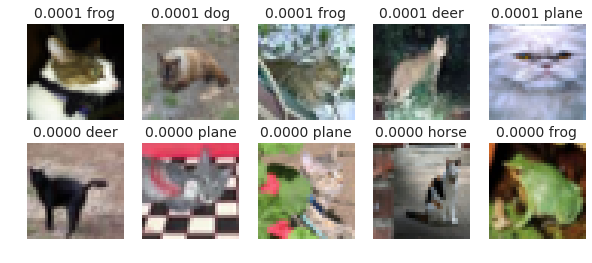

In [144]:
plot_least_confident_incorrect_by_recall(3, y_pred_, y_true_, testset, classes, 
                                         nrows=2, untransform=untransform)

Note: that last example really does look like a frog, not a cat. It appears that the label is wrong.

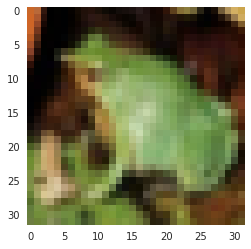

cat


In [41]:
imshow(testset.test_data[2405])
print(classes[testset.test_labels[2405]])

Show the most uncertain predictions across the entire dataset. The labels are the predicted labels.

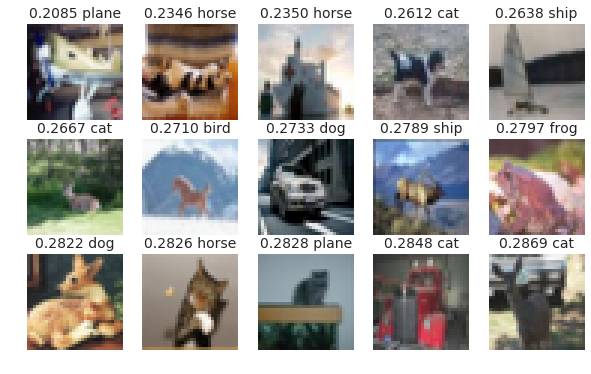

In [145]:
plot_most_uncertain(y_pred_, y_true_, testset, classes, 15, 3, untransform)

## Making new predictions

Make a prediction on a picture that is not in the dataset:

In [111]:
resize_transform = transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # resize to 32x32
    transform_test                            # + previous transforms
])

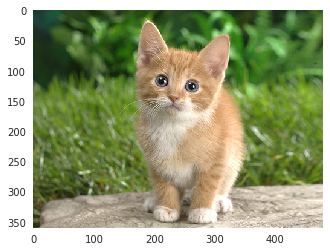

In [112]:
img = PIL.Image.open("cat.jpg")
imshow(img)

In [113]:
img_tensor = resize_transform(img).unsqueeze(0)
y_pred = predict_on_batch(net, img_tensor)
y_pred.size()

torch.Size([1, 10])

In [114]:
y_pred

Variable containing:

Columns 0 to 7 
-10.7553  -7.3902   2.2871   8.4853   8.8478   7.7131  -1.8508   4.7644

Columns 8 to 9 
 -6.2503  -4.9973
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

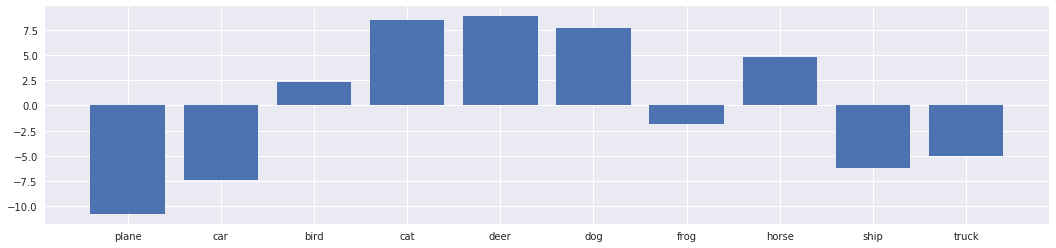

In [115]:
plot_predictions(y_pred.squeeze(), classes)

The predictions are before the softmax, since we use `CrossEntropyLoss`. Compute the softmax manually to get percentages:

In [116]:
y_pred_softmax = F.softmax(y_pred.squeeze(), dim=0)

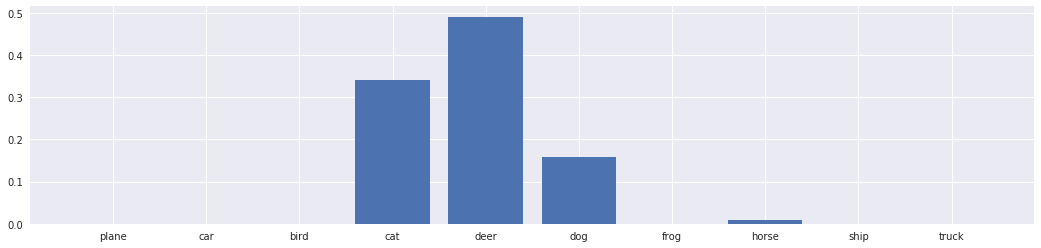

In [117]:
plot_predictions(y_pred_softmax, classes)

In [118]:
print_top5(y_pred_softmax, classes)

0.49121 deer
0.34186 cat
0.15794 dog
0.00828 horse
0.00070 bird


Looks like we need a better model! :-)

## Visualizations

The weights of the first conv layer:

In [123]:
W = net.conv1.conv.weight
W.size()

torch.Size([16, 3, 3, 3])

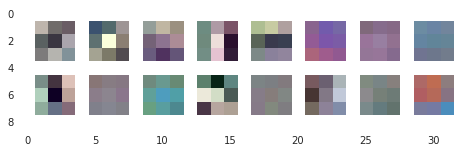

In [124]:
grid = torchvision.utils.make_grid(W.data.cpu(), normalize=True, padding=1, pad_value=1, nrow=8)
imshow(grid, figsize=(8, 8))

Get the output of an intermediate layer (here the second convolution layer):

In [77]:
output = forward(net, [net.conv2], img_tensor)[0]
output.size()

torch.Size([1, 32, 16, 16])

In [127]:
# Use this to grab the output *before* the ReLU:
output = net.conv1.conv(make_var(img_tensor))

Histogram of the activations of this layer:

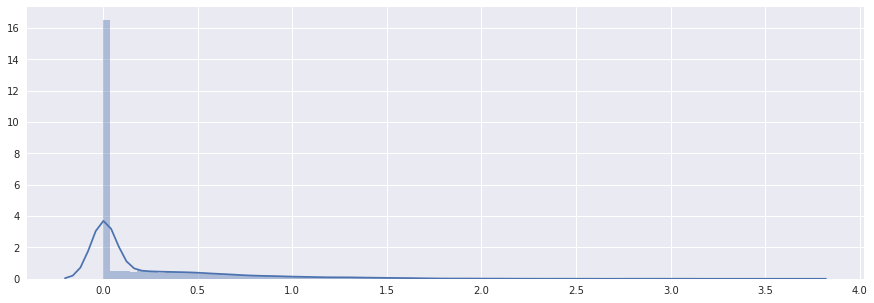

In [78]:
feat = output.data.cpu().numpy().ravel()
fig = plt.figure(figsize=(15, 5))
sns.distplot(feat, bins=100)
plt.show()

Activations of this layer, where each feature map is a grayscale image.

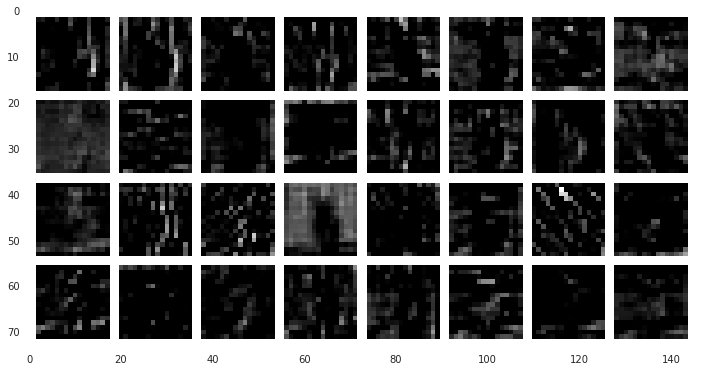

In [79]:
data = output.data.cpu().permute(1, 0, 2, 3)
grid = torchvision.utils.make_grid(data, normalize=True, padding=2, pad_value=1, nrow=8)
imshow(grid, figsize=(12, 12))

## Find similar images

If two images produce activations that are similar (i.e. have a small Euclidian distance), then we can consider those images to have similar contents. We can do this at different layers in the network.

In [80]:
# Computes the (intermediate) activations for all test images.
def compute_activations(layer):
    activations = []
    handle = layer.register_forward_hook(lambda module, inp, out: activations.append(out))
    _ = predict(net, testloader, verbose=True)
    handle.remove()

    # Combine into one big tensor.
    activations = torch.cat(activations, dim=0)
    return activations

In [82]:
activations = compute_activations(net.fc1).view(-1, 128)
activations.size()

79/79 ██████████████████████████████ ETA 0s


torch.Size([10000, 128])

In [83]:
def plot_similar_images(activations, compare_with, N=20):
    # Compute the Euclidian distance between the chosen image and
    # every other image in the test set.
    distances = (activations[compare_with] - activations).norm(dim=1)

    # Sort by smallest distance. The "compare_with" image always shows up as
    # the first image because its distance with itself is 0.
    _, indices = torch.sort(distances, dim=0)
    closest_images = indices[:N].data.cpu().numpy()

    # Gather the images.
    image_data = []
    for i, ix in enumerate(closest_images):
        image_data.append(testset[ix][0])
    image_data = torch.stack(image_data, dim=0)

    # Plot them.
    grid = torchvision.utils.make_grid(image_data, normalize=True, padding=2, pad_value=1, nrow=5)
    imshow(grid, figsize=(8, 8))

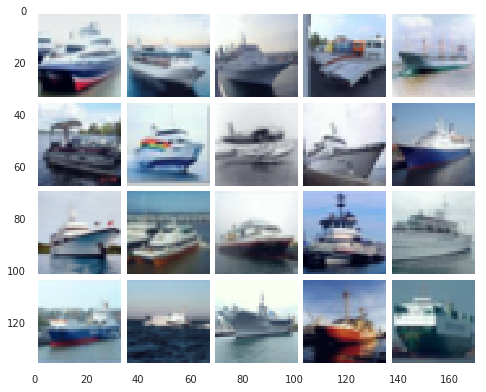

In [85]:
plot_similar_images(activations, 1)

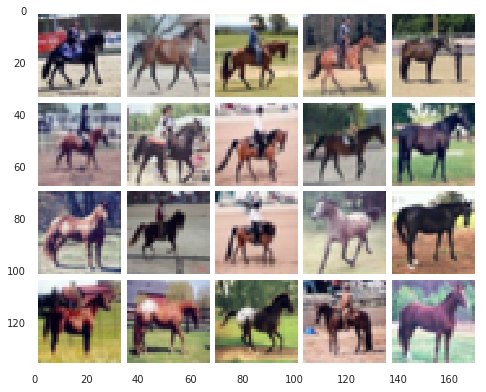

In [84]:
plot_similar_images(activations, 5000)

## What do filters learn?

We can find out which images activate certain convolution filters the most.

In [162]:
def predict_norm(model, layer, channel, data_loader):
    model.train(False)

    num_samples = data_loader_sample_count(data_loader)
    output = torch.zeros(num_samples,)
    offset = 0
    
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        batch_pred = forward(model, [layer], inputs)[0]
        batch_size = batch_pred.size(0)
        
        # Compute the L1 norm for the activations of each example in
        # the given channel channel.
        norm = batch_pred.data[:, channel, :, :].contiguous()
        norm = norm.view(-1, norm.size(1)*norm.size(2)).norm(p=1, dim=1)

        output[offset:offset + batch_size, ...] = norm
        offset += batch_size

    return output


def plot_images_with_largest_activations(activations, labels, dataset, classes, k, nrows, untransform=None):
    idxs = np.argsort(activations)[-k:][::-1]

    titles = []
    for i, idx in enumerate(idxs):
        titles.append(classes[labels[idx]])

    plot_images_from_indices_with_titles(idxs, dataset, titles, nrows, untransform)

In [22]:
y_true_ = np.array(testset.test_labels)

First conv layer. We'd expect this to capture simple patterns:

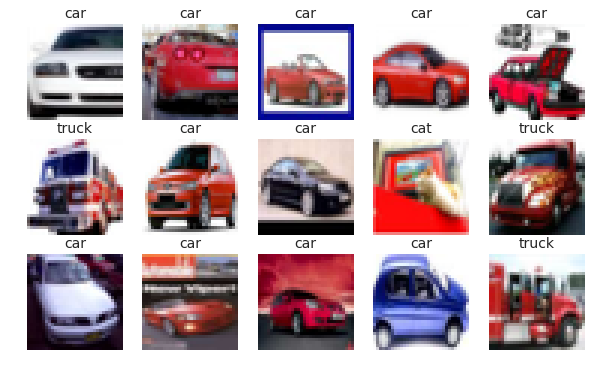

In [170]:
output = predict_norm(net, net.conv1, 2, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

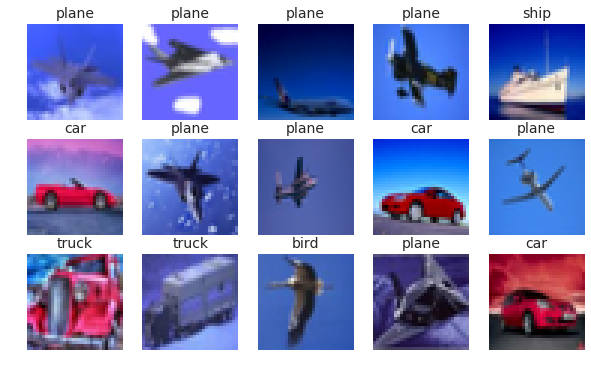

In [171]:
output = predict_norm(net, net.conv1, 5, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

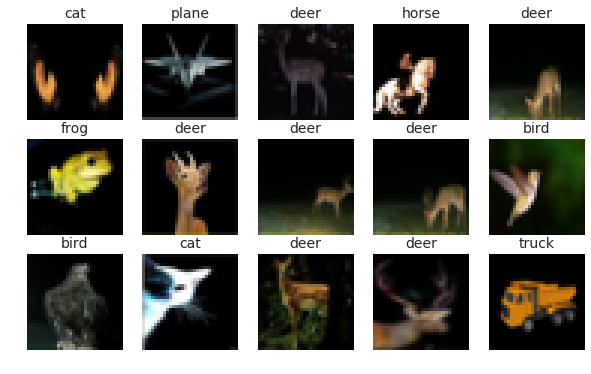

In [182]:
output = predict_norm(net, net.conv1, 14, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

Second conv layer:

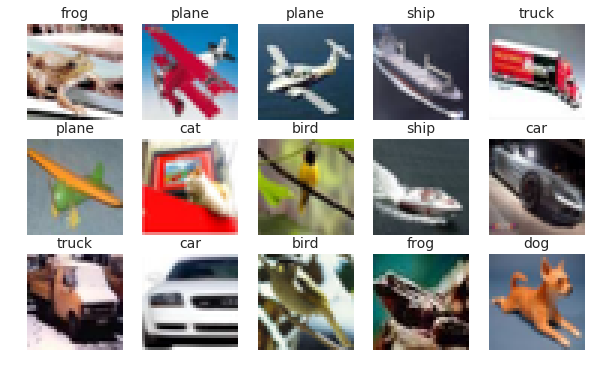

In [188]:
output = predict_norm(net, net.conv2, 4, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

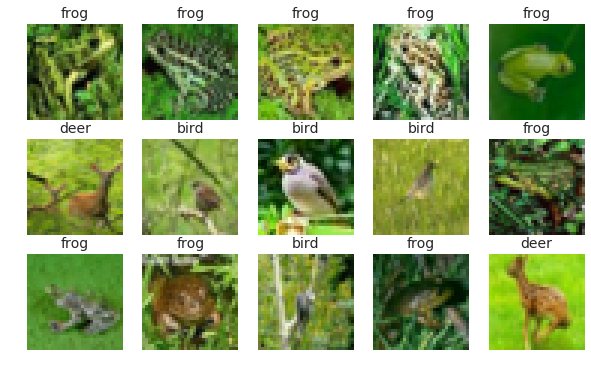

In [189]:
output = predict_norm(net, net.conv2, 19, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

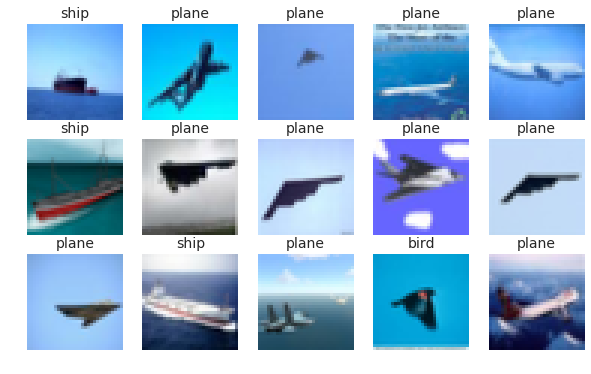

In [190]:
output = predict_norm(net, net.conv2, 23, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

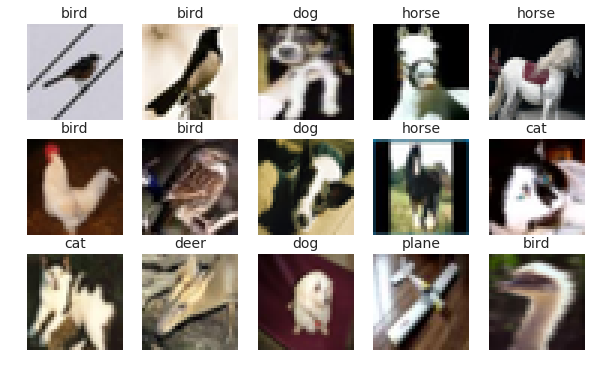

In [196]:
output = predict_norm(net, net.conv2, 27, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

The third conv layer. This should start to capture higher-level concepts:

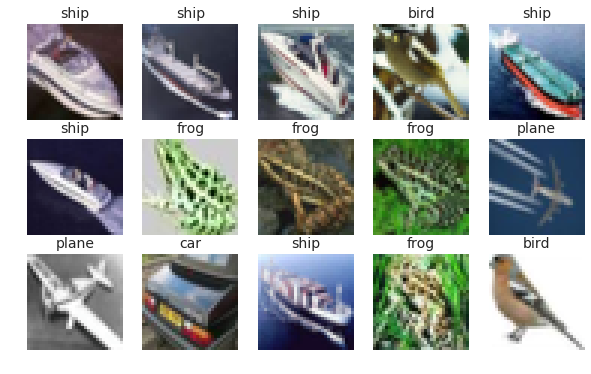

In [197]:
output = predict_norm(net, net.conv3, 3, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

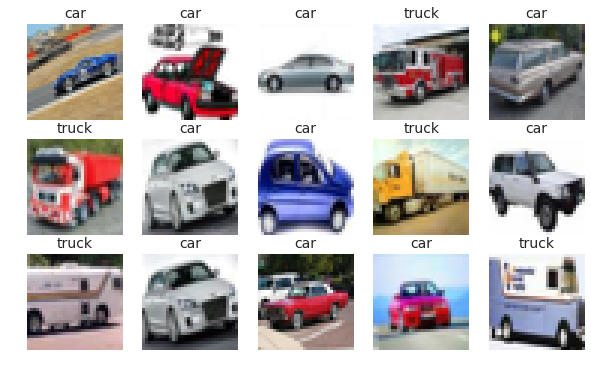

In [199]:
output = predict_norm(net, net.conv3, 8, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

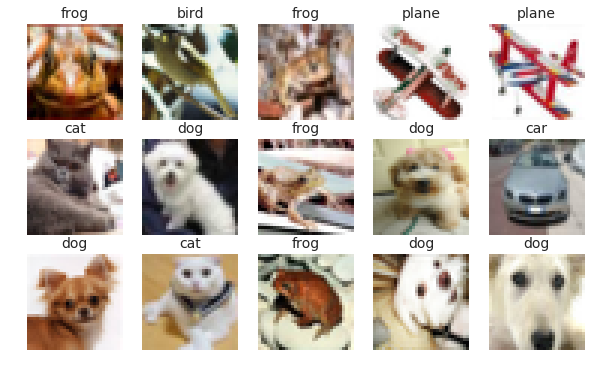

In [200]:
output = predict_norm(net, net.conv3, 14, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

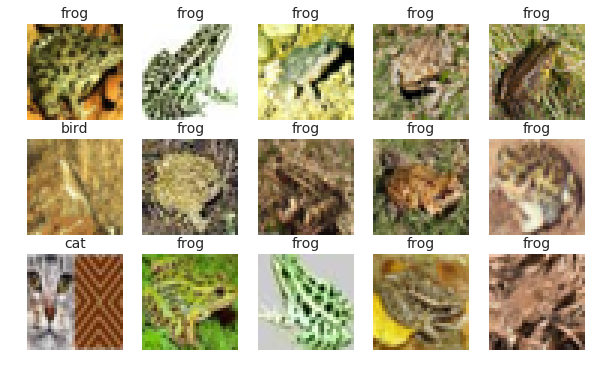

In [206]:
output = predict_norm(net, net.conv3, 21, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)

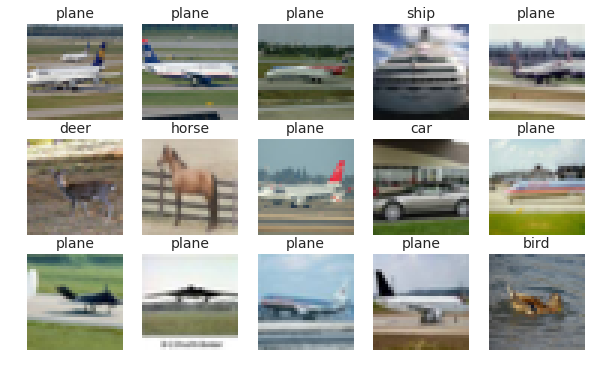

In [211]:
output = predict_norm(net, net.conv3, 60, testloader)
plot_images_with_largest_activations(output.numpy(), y_true_, testset, classes, 15, 3, untransform)